## Wavelet Noise Analyzer

In [9]:
import os
import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import csv

In [10]:
def display_image_and_spectrum(image_path, spectrum_path, magnitude_csv_path, fig_title=""):
    """
    Displays the noise image, its BMP spectrum, and a plot from its magnitude CSV.
    """
    try:
        img = Image.open(image_path)
    except FileNotFoundError:
        print(f"Image file not found: {image_path}")
        img = None
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        img = None

    try:
        spec_img = Image.open(spectrum_path)
    except FileNotFoundError:
        print(f"Spectrum BMP file not found: {spectrum_path}")
        spec_img = None
    except Exception as e:
        print(f"Error loading spectrum BMP {spectrum_path}: {e}")
        spec_img = None

    magnitudes = None
    if magnitude_csv_path and os.path.exists(magnitude_csv_path):
        try:
            # Read CSV, it contains already FFT-shifted magnitudes
            magnitudes = np.loadtxt(magnitude_csv_path, delimiter=',')
        except Exception as e:
            print(f"Error loading or processing magnitude CSV {magnitude_csv_path}: {e}")
            magnitudes = None
    elif magnitude_csv_path:
        print(f"Magnitude CSV file not found: {magnitude_csv_path}")


    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(fig_title, fontsize=16)

    # Display Noise Image
    axs[0].set_title(f"Noise Image: {os.path.basename(image_path)}")
    if img:
        axs[0].imshow(np.array(img)) 
    axs[0].axis('off')

    # Display Spectrum BMP (log-scaled by C++)
    axs[1].set_title(f"Spectrum BMP: {os.path.basename(spectrum_path)}")
    if spec_img:
        axs[1].imshow(np.array(spec_img), cmap='inferno') 
    axs[1].axis('off')

    # Display Spectrum from CSV (log-scaled here for comparison/control)
    axs[2].set_title(f"Log-Mag from CSV: {os.path.basename(magnitude_csv_path or 'N/A')}")
    if magnitudes is not None:
        log_mags_from_csv = np.log1p(magnitudes) # log1p(x) = log(1+x)
        
        min_val = np.min(log_mags_from_csv)
        max_val = np.max(log_mags_from_csv)
        if max_val > min_val:
            norm_log_mags = (log_mags_from_csv - min_val) / (max_val - min_val)
        else:
            norm_log_mags = np.zeros_like(log_mags_from_csv)

        axs[2].imshow(norm_log_mags, cmap='inferno', aspect='auto')
    axs[2].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [13]:
def main_analyzer():
    print("Python Analyzer Script")
    print("Looking for BMP and CSV files generated by C++...")

    # Slices from tile generation process
    debug_prefixes = [
        "debug_R_initial",
        "debug_R_down_up",
        "debug_N_intermediate",
        "debug_N_final"
    ]
    
    found_slice_num_str = None
    # Try to find a representative file to extract the slice number
    # Let's use debug_N_final_slice_z*.bmp as it's the last one generated in that sequence
    n_final_slice_files = glob.glob("debug_N_final_slice_z*.bmp")
    if n_final_slice_files:
        # Sort to get a consistent file if multiple match (e.g. different tile sizes run previously)
        n_final_slice_files.sort()
        basename = os.path.basename(n_final_slice_files[-1]) # Take the last one, likely most recent
        try:
            # Corrected parsing: Handles filenames with or without "_spectrum"
            # e.g., "debug_N_final_slice_z64_spectrum.bmp" is now correctly handled.
            slice_part = basename.split('_slice_z')[1].split('.bmp')[0]
            found_slice_num_str = slice_part.split('_spectrum')[0]
            print(f"Detected slice number: '{found_slice_num_str}' from {basename}")
        except IndexError:
            print(f"Could not parse slice number from {basename}. Structure might be unexpected.")
    else:
        print("No 'debug_N_final_slice_z*.bmp' files found to determine slice number.")

    if found_slice_num_str:
        for prefix in debug_prefixes:
            img_path = f"{prefix}_slice_z{found_slice_num_str}.bmp"
            spec_path = f"{prefix}_slice_z{found_slice_num_str}_spectrum.bmp"
            csv_path = f"{prefix}_slice_z{found_slice_num_str}_spectrum_magnitude.csv"

            # Check if all necessary files exist before attempting to display
            # Note: The original image (without _spectrum) is now optional, as the primary analysis
            # might be on the spectrum files themselves. We will proceed if the spectrum file exists.
            
            # Let's adjust the condition to primarily check for the spectrum file,
            # as that seems to be the key file based on the error.
            # We will still check for the base image for display purposes.
            
            base_name_for_log = f"{prefix}_slice_z{found_slice_num_str}"

            # We need at least the spectrum bmp to proceed.
            if os.path.exists(spec_path):
                print(f"\n--- Analyzing: {base_name_for_log} ---")
                
                # The original image is for context, can be missing.
                if not os.path.exists(img_path):
                    print(f"  (Optional image missing: {img_path})")

                display_image_and_spectrum(
                    img_path if os.path.exists(img_path) else None,
                    spec_path,
                    csv_path if os.path.exists(csv_path) else None,
                    fig_title=f"Analysis for {prefix} (Slice {found_slice_num_str})"
                )
            else:
                print(f"\n--- Skipping: {base_name_for_log} (missing files) ---")
                if not os.path.exists(spec_path): 
                    print(f"  Missing required spectrum BMP: {spec_path}")
                if not os.path.exists(img_path): 
                    print(f"  (Optional image missing: {img_path})")
                if not os.path.exists(csv_path): 
                    print(f"  (Optional CSV missing: {csv_path})")
    else:
        print("Skipping debug slice analysis as slice number could not be determined.")

    # Diagnostic base band (evaluation of N_final tile)
    print("\n--- Analyzing: Diagnostic Base Band ---")
    diag_img_path = "diagnostic_base_band.bmp"
    diag_spec_path = "diagnostic_base_band_spectrum.bmp"
    diag_csv_path = "diagnostic_base_band_spectrum_magnitude.csv"

    if os.path.exists(diag_img_path) and os.path.exists(diag_spec_path):
        display_image_and_spectrum(
            diag_img_path,
            diag_spec_path,
            diag_csv_path if os.path.exists(diag_csv_path) else None,
            fig_title="Diagnostic Base Band (N(x))"
        )
    else:
        print("Could not find full set for diagnostic_base_band files.")
        if not os.path.exists(diag_img_path): print(f"  Missing: {diag_img_path}")
        if not os.path.exists(diag_spec_path): print(f"  Missing: {diag_spec_path}")


Python Analyzer Script
Looking for BMP and CSV files generated by C++...
Detected slice number: '64' from debug_N_final_slice_z64_spectrum.bmp

--- Analyzing: debug_R_initial_slice_z64 ---


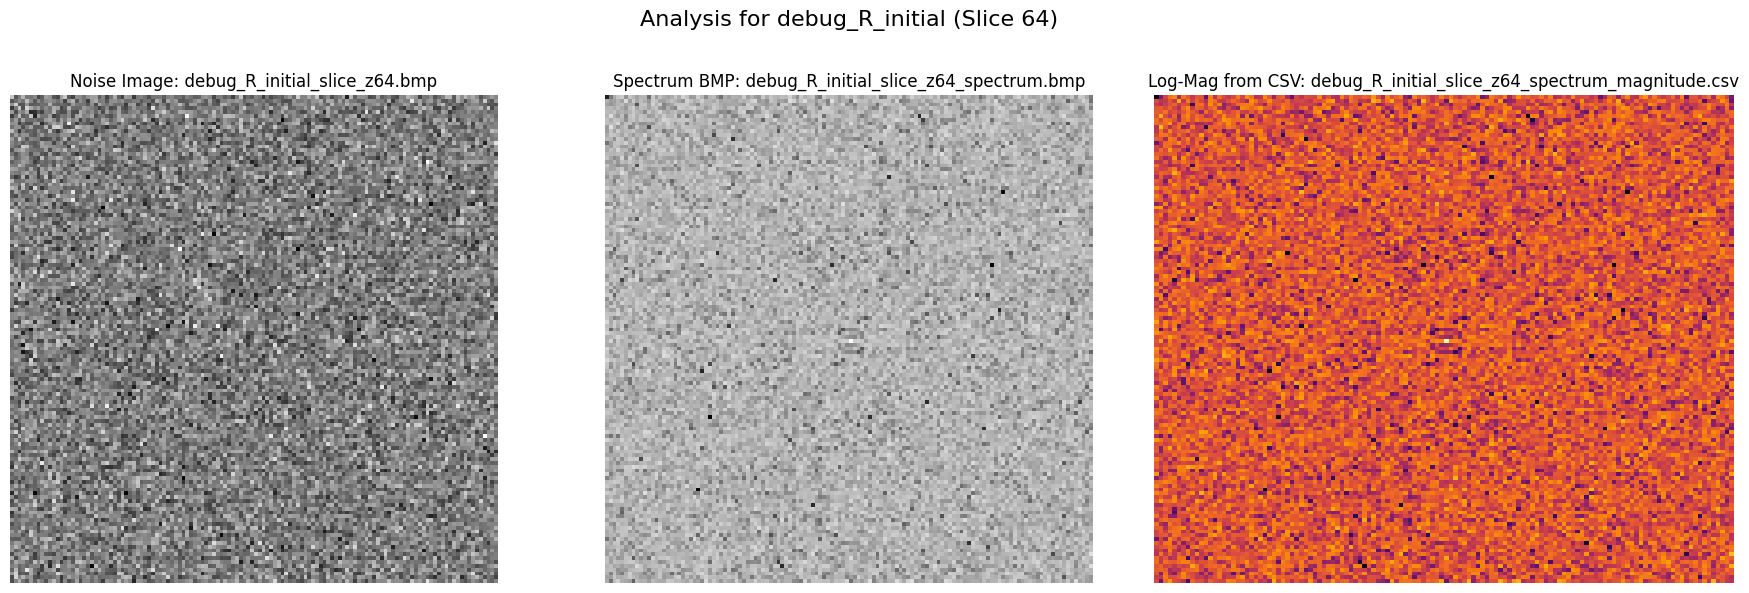


--- Analyzing: debug_R_down_up_slice_z64 ---


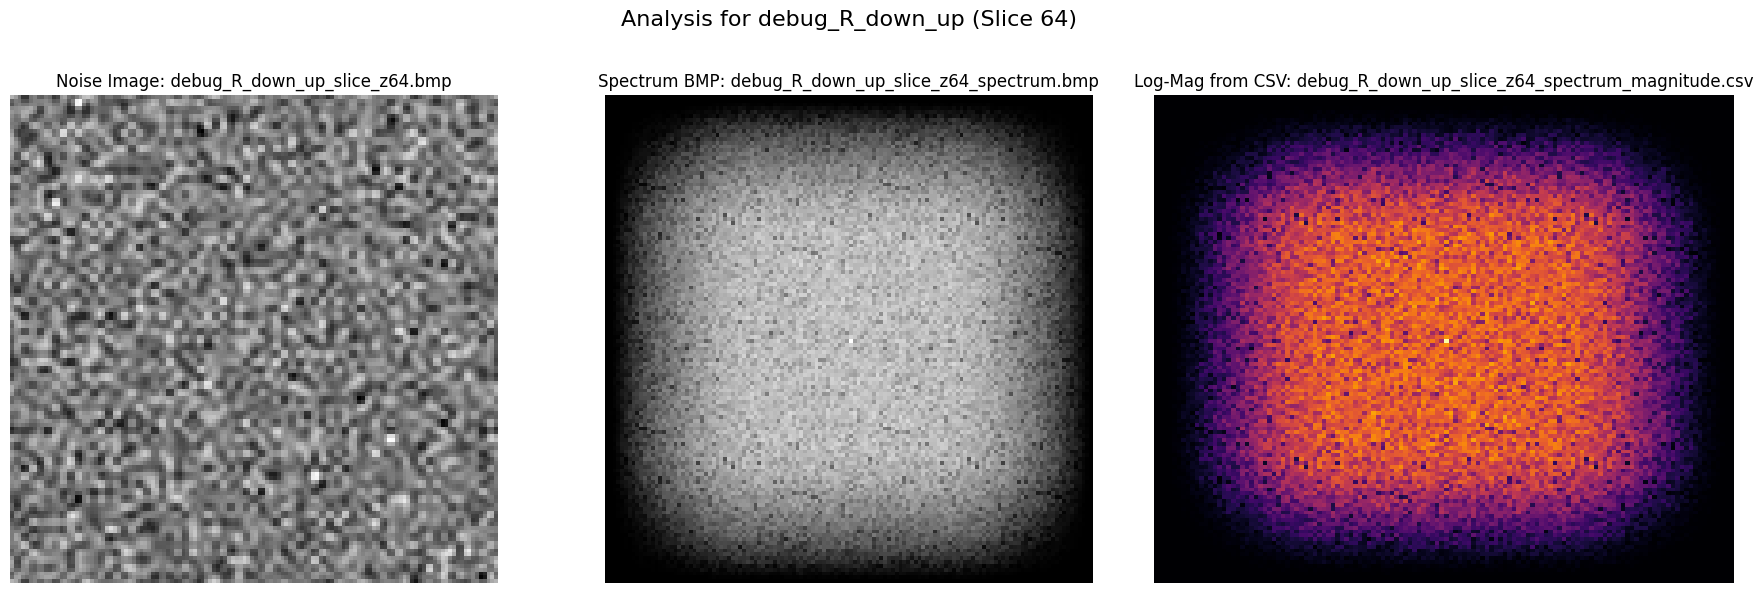


--- Analyzing: debug_N_intermediate_slice_z64 ---


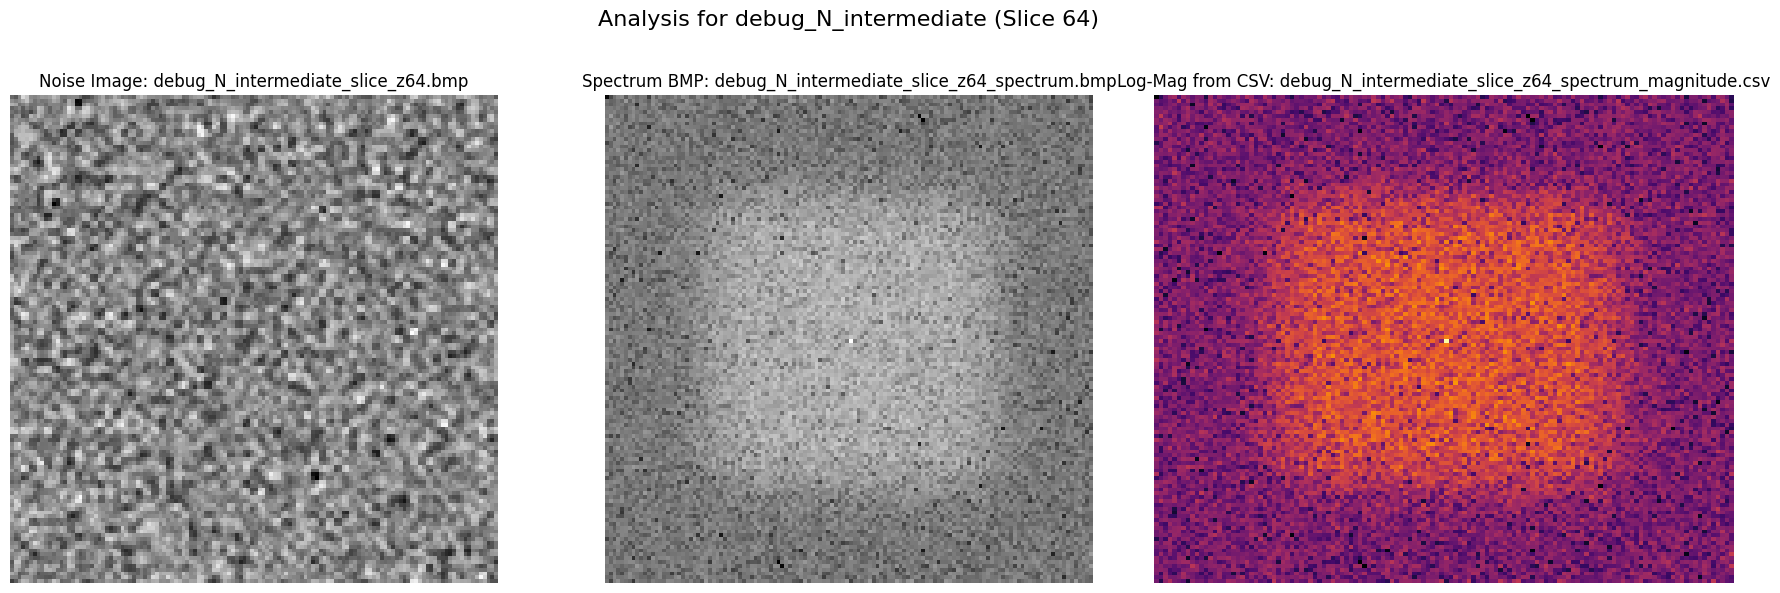


--- Analyzing: debug_N_final_slice_z64 ---


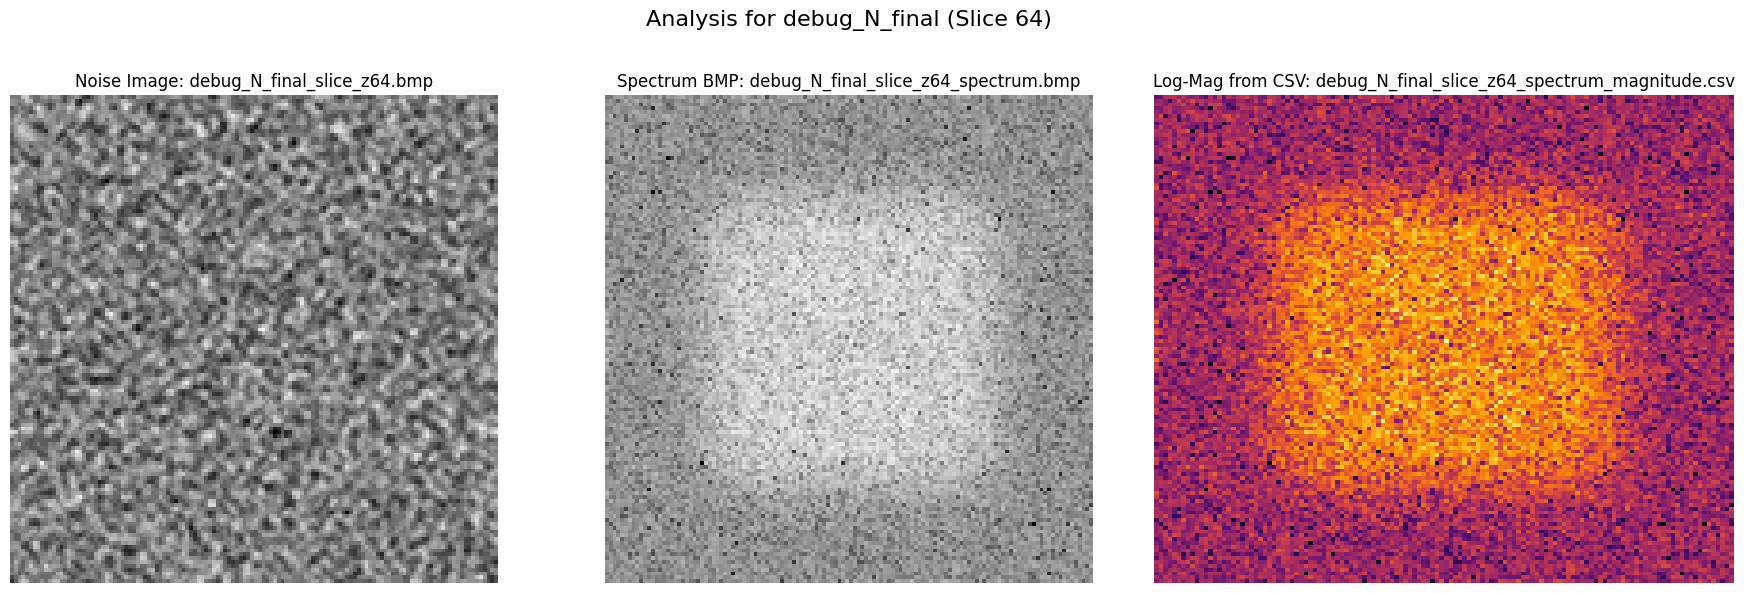


--- Analyzing: Diagnostic Base Band ---


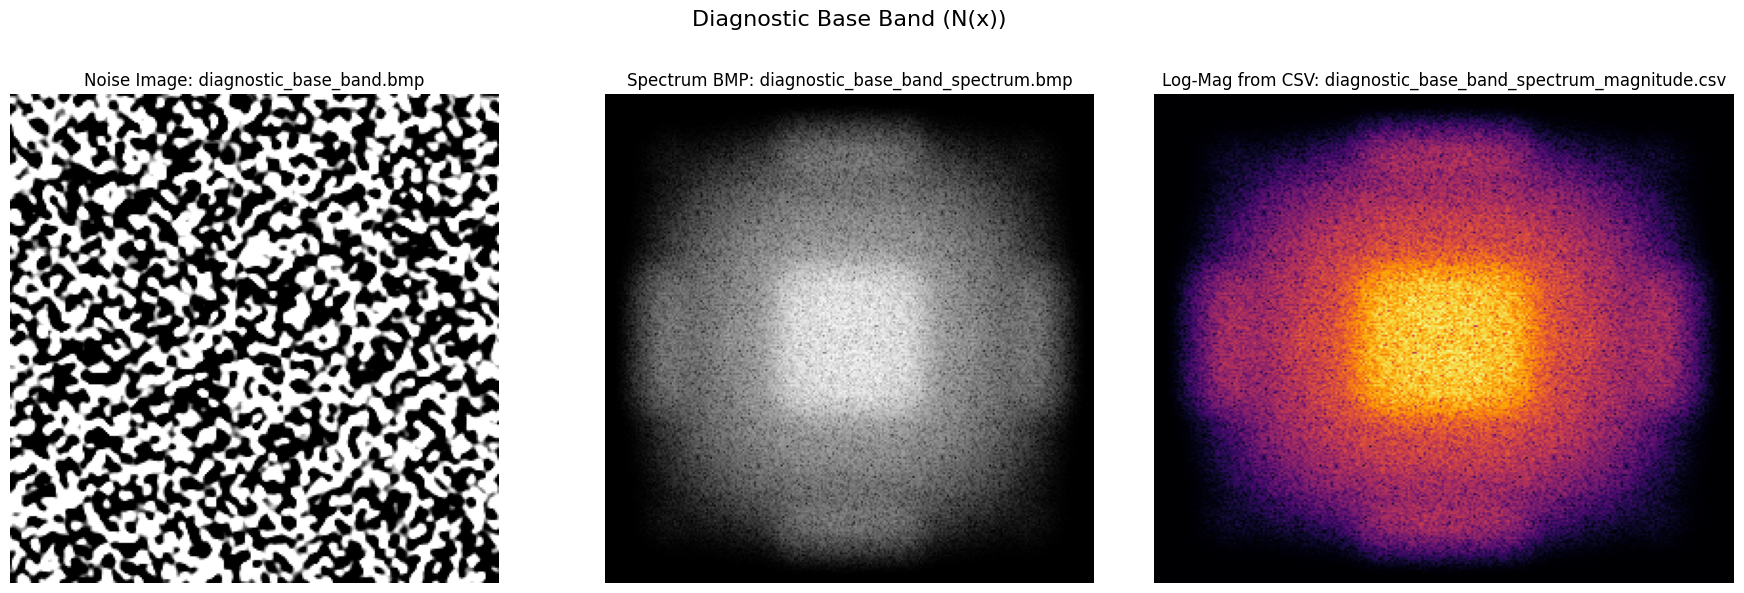

In [12]:
if __name__ == "__main__":
    # This ensures the code runs when the notebook cell is executed directly
    # or if you were to convert this notebook back to a .py script and run it.
    main_analyzer()